# 1. Module

In [ ]:
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import torchvision as tv
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline
#--------------------------------Thư viện cần thiết cho vẽ ------------------
from __future__ import division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(5)
from torchvision import transforms


In [ ]:
from __future__ import division

import os, sys, pdb, shutil, time, random, datetime
import argparse
import torch
import torch.optim.lr_scheduler as lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision.datasets as dset
import torchvision.transforms as transforms


In [ ]:
!git clone https://github.com/waleedka/hiddenlayer.git #Use to show graph model

Cloning into 'hiddenlayer'...
remote: Enumerating objects: 364, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 364 (delta 35), reused 27 (delta 27), pack-reused 321
Receiving objects: 100% (364/364), 4.46 MiB | 23.55 MiB/s, done.
Resolving deltas: 100% (191/191), done.


In [ ]:
import hiddenlayer.hiddenlayer as hl

**Default constant**

In [ ]:
MODELNAME = "cifar.model"
EPOCH = 30
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 2. Load data

**train and test**

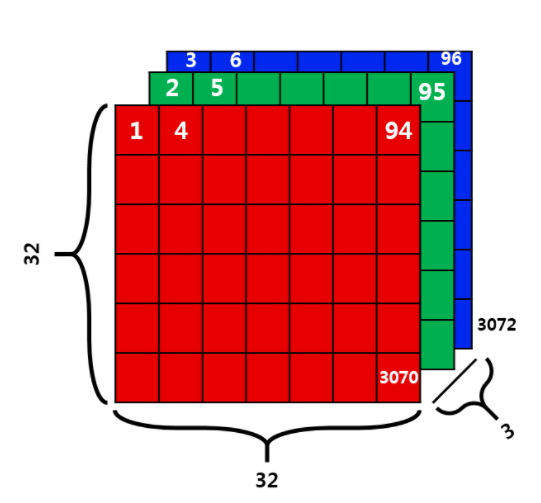

100%|██████████| 170498071/170498071 [00:05<00:00, 28910638.28it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified
Bộ CIFAR có : 50000 dữ liệu Train, 10000 dữ liệu test


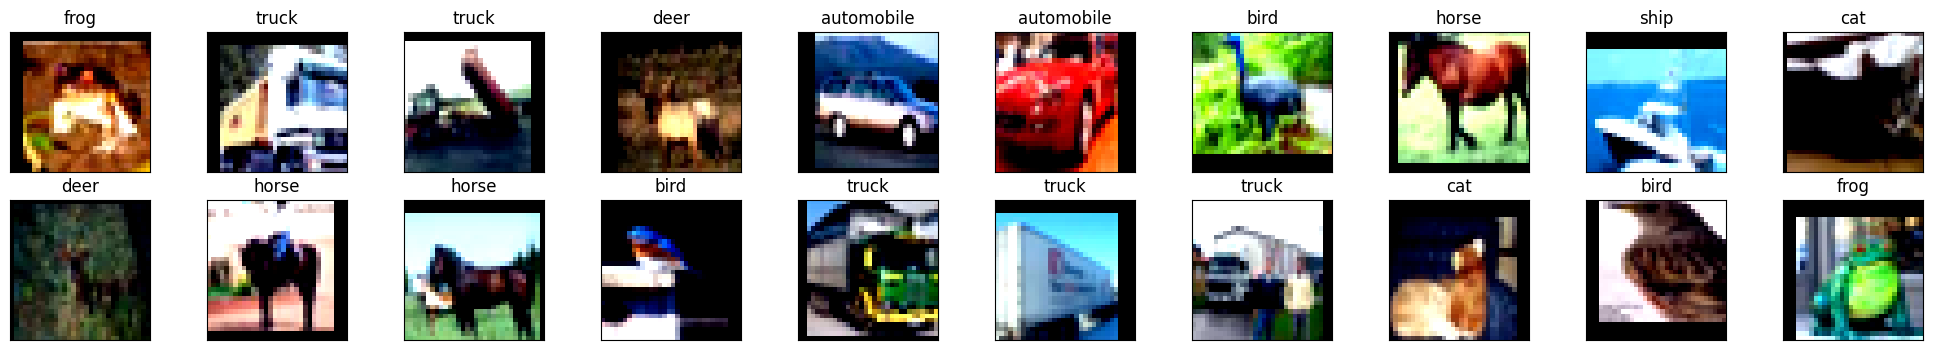

In [ ]:
class Loader_Data(): #Class has data
  def __init__(self):
    mean = [x / 255 for x in [125.3, 123.0, 113.9]] # Mean
    std = [x / 255 for x in [63.0, 62.1, 66.7]]#Standard Deviation
    train_transform = transforms.Compose([ transforms.RandomCrop(32, padding=4),transforms.RandomHorizontalFlip(), transforms.ToTensor(),transforms.Normalize(mean, std)])
    test_transform = transforms.Compose([transforms.CenterCrop(32), transforms.ToTensor(), transforms.Normalize(mean, std)])
    # load the dataset
    train_dataset = CIFAR10(root='./', train=True, download=True, transform=train_transform)

    self.train_dataset=train_dataset
    self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)

    self.test_dataset = CIFAR10(root='./', train=False,transform=test_transform,download = True)
    self.test_loader = DataLoader(dataset=self.test_dataset, batch_size=100, shuffle=False) #Test
    print("Bộ CIFAR có : {} dữ liệu Train, {} dữ liệu test".format(len(train_dataset),len(self.test_dataset)))

    self.classes=['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
  def Show_img(self):
    dataiter = iter(self.train_loader)
    images, labels = next(dataiter)
    images = images.numpy() # convert images to numpy for display
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    # display 20 images
    for idx in np.arange(20):
      ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
      img = images[idx].copy() / 2 + 0.5
      plt.imshow(np.transpose(img, (1, 2, 0)))
      ax.set_title(self.classes[labels[idx]])
  def Show_Graph_Train(self):
    num_each_class={'airplane':0, 'automobile':0, 'bird':0, 'cat':0, 'deer':0,'dog':0, 'frog':0, 'horse':0, 'ship':0, 'truck':0}
    values=[]
    dataiter = iter(self.train_loader)
    images, labels = next(dataiter)
    for i,j in self.train_dataset:
      num_each_class[self.classes[j]]+=1

    for i,j in num_each_class.items():
      print("Class {} have {} objects".format(i,j))
      values.append(j)
    names=self.classes
    plt.figure(figsize=(30, 3))
    plt.subplot(131)
    plt.bar(names, values)
    plt.subplot(132)
    plt.scatter(names, values)
    plt.subplot(133)
    plt.plot(names, values)
    plt.suptitle('Train Plotting')
    plt.show()
  def Show_Graph_Test(self):
    num_each_class={'airplane':0, 'automobile':0, 'bird':0, 'cat':0, 'deer':0,'dog':0, 'frog':0, 'horse':0, 'ship':0, 'truck':0}
    values=[]
    for i,j in self.test_dataset:
      num_each_class[self.classes[j]]+=1
    for i,j in num_each_class.items():
      print("Class {} have {} objects".format(i,j))
      values.append(j)
    names=self.classes
    plt.figure(figsize=(30, 3))
    plt.subplot(131)
    plt.bar(names, values)
    plt.subplot(132)
    plt.scatter(names, values)
    plt.subplot(133)
    plt.plot(names, values)
    plt.suptitle('Test Plotting')
    plt.show()
  def Show_Graph(self):
    self.Show_Graph_Train()
    self.Show_Graph_Test()

Data=Loader_Data()
Data.Show_img()



Class airplane have 5000 objects
Class automobile have 5000 objects
Class bird have 5000 objects
Class cat have 5000 objects
Class deer have 5000 objects
Class dog have 5000 objects
Class frog have 5000 objects
Class horse have 5000 objects
Class ship have 5000 objects
Class truck have 5000 objects


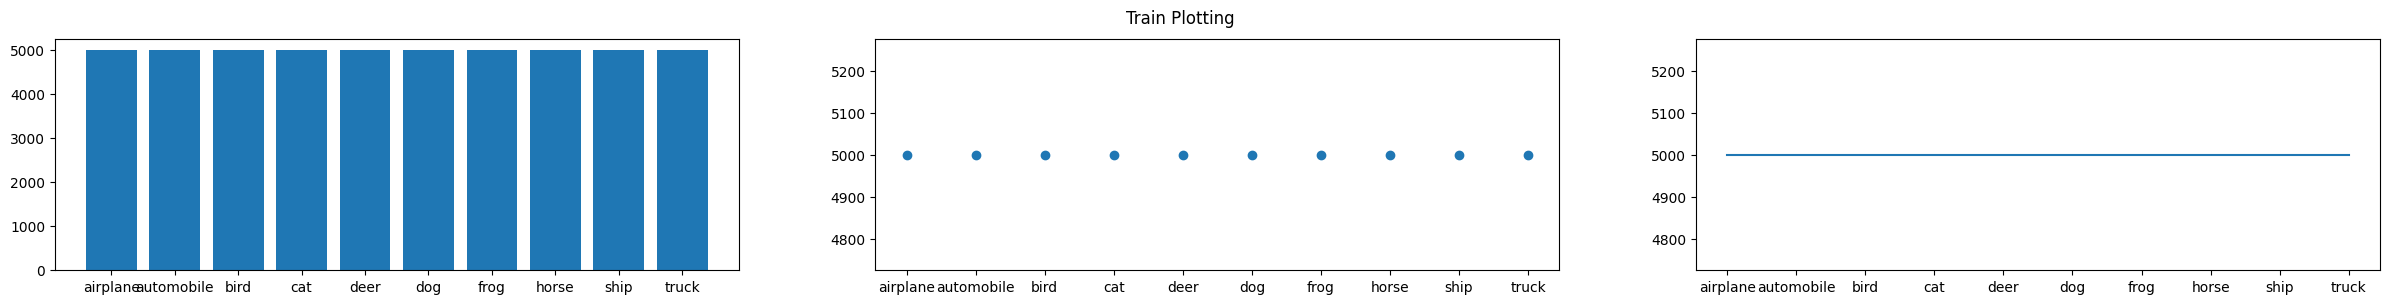

Class airplane have 1000 objects
Class automobile have 1000 objects
Class bird have 1000 objects
Class cat have 1000 objects
Class deer have 1000 objects
Class dog have 1000 objects
Class frog have 1000 objects
Class horse have 1000 objects
Class ship have 1000 objects
Class truck have 1000 objects


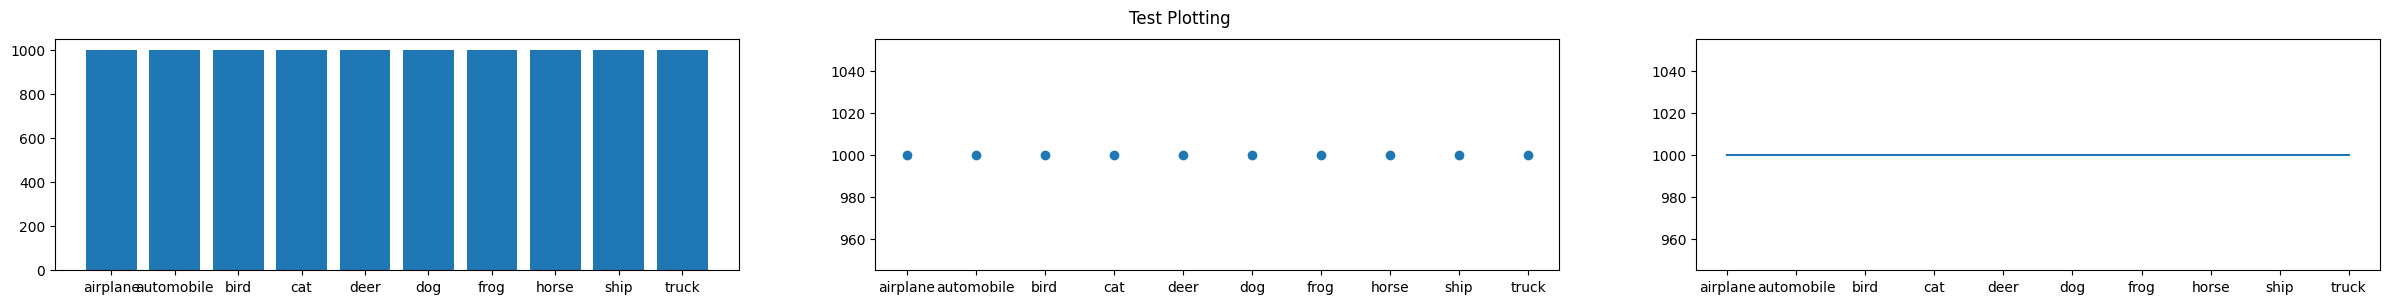

In [ ]:
Data.Show_Graph()

# 3. Model

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class simplenet(nn.Module):
    def __init__(self, classes=10, simpnet_name='simplenet'):
        super(simplenet, self).__init__()
        #print(simpnet_name)
        self.features = self._make_layers() #Create Layer by method in class simple net
        self.classifier = nn.Linear(256, classes) #Linear to 10
        self.drp = nn.Dropout(0.1) #  Drop Out with p=0.1

    def load_my_state_dict(self, state_dict): #Load model

        own_state = self.state_dict()

        for name, param in state_dict.items(): #Get param in location (where have model)
            name = name.replace('module.', '')
            if name not in own_state:
                # print(name)
                continue
            if isinstance(param, Parameter): #If param == The parameter of model => Get data
                # backwards compatibility for serialized parameters
                param = param.data
            print("STATE_DICT: {}".format(name))
            try:
                own_state[name].copy_(param)
            except:
                print('While copying the parameter named {}, whose dimensions in the model are'
                      ' {} and whose dimensions in the checkpoint are {}, ... Using Initial Params'.format(
                    name, own_state[name].size(), param.size()))

    def forward(self, x):
        # print(x.shape)
        #Shape X = [-1, 64, 32, 32]
        out = self.features(x) #X to model's layers
        # print(out.shape)
        #Global Max Pooling
        out = F.max_pool2d(out, kernel_size=out.size()[2:])

        # out = F.dropout2d(out, 0.1, training=True)
        out = self.drp(out) # Regularization parameter [-1, 256, 1, 1]

        out = out.view(out.size(0), -1)

        out = self.classifier(out) #[-1, 10]
        return out

    def _make_layers(self):

        model = nn.Sequential(
            #Layer 1
                             nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)), #[-1, 64, 32, 32]
                             nn.BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True), # [-1, 64, 32, 32]
                             nn.ReLU(inplace=True),  # [-1, 64, 32, 32]
            #Layer 2
                             nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)), # [-1, 128, 32, 32]
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True), # [-1, 128, 32, 32]
                             nn.ReLU(inplace=True), # From [-1, 128, 32, 32] in ReLU
            #Layer 3
                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)), #The Shape: [-1, 128, 32, 32]
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True), #The Shape: [-1, 128, 32, 32]
                             nn.ReLU(inplace=True), # Shape:[-1, 128, 32, 32]
            #Layer 4
                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),  # Shape: [-1, 128, 32, 32]
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),# Shape:[-1, 128, 32, 32]
                             nn.ReLU(inplace=True), # Shape:[-1, 128, 32, 32]


                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False), #through the Max_pool2d : The Shape: [-1, 128, 16, 16]
                             nn.Dropout2d(p=0.1),#Shape:[-1, 128, 16, 16]

            #Layer 5
                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),#Shape:[-1, 128, 16, 16]
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),#Shape:[-1, 128, 16, 16]
                             nn.ReLU(inplace=True),#Shape:[-1, 128, 16, 16]
            #Layer 6
                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),#Shape:[-1, 128, 16, 16]
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),#Shape:[-1, 128, 16, 16]
                             nn.ReLU(inplace=True),#Shape:[-1, 128, 16, 16]
            #Layer 7
                             nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),#Shape:[-1, 128, 16, 16]
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),#Shape:[-1, 128, 16, 16]
                             nn.ReLU(inplace=True),#Shape:[-1, 128, 16, 16]



                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False), #Shape:[-1, 256, 8, 8]
                             nn.Dropout2d(p=0.1),#Shape:[-1, 256, 8, 8]
            #Layer 8

                             nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),#Shape:[-1, 256, 8, 8]
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),#Shape:[-1, 256, 8, 8]
                             nn.ReLU(inplace=True),#Shape:[-1, 256, 8, 8]

            #Layer 9
                             nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),#Shape:[-1, 256, 8, 8]
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),#Shape:[-1, 256, 8, 8]
                             nn.ReLU(inplace=True),#Shape:[-1, 256, 8, 8]



                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False), #Shape:[-1, 256, 4, 4]
                             nn.Dropout2d(p=0.1),#Shape:[-1, 256, 4, 4]

            #Layer 10

                             nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),#Shape:[-1, 256, 4, 4]
                             nn.BatchNorm2d(512, eps=1e-05, momentum=0.05, affine=True),#Shape:[-1, 256, 4, 4]
                             nn.ReLU(inplace=True),#Shape:[-1, 256, 4, 4]



                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),#Shape:[-1, 512, 2, 2]
                             nn.Dropout2d(p=0.1),#Shape:[-1, 512, 2, 2]
            #Layer 11

                             nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), padding=(0, 0)),#Shape:[-1, 2048, 2, 2]
                             nn.BatchNorm2d(2048, eps=1e-05, momentum=0.05, affine=True),#Shape:[-1, 2048, 2, 2]
                             nn.ReLU(inplace=True),#Shape:[-1, 2048, 2, 2]

            #Layer 12

                             nn.Conv2d(2048, 256, kernel_size=[1, 1], stride=(1, 1), padding=(0, 0)),#Shape:[-1, 256,2, 2]
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),#Shape:[-1, 256, 2, 2]
                             nn.ReLU(inplace=True),#Shape:[-1, 256, 2, 2]


                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),#Shape:[-1, 256, 1,1]
                             nn.Dropout2d(p=0.1),#Shape:[-1, 256, 1, 1]
            #Layer 13

                             nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),#Shape:[-1, 256, 1, 1]
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),#Shape:[-1, 256, 1, 1]
                             nn.ReLU(inplace=True),#Shape:[-1, 256, 1, 1]

                            )

        for m in model.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))

        return model

In [ ]:
from torchsummary import summary
model = simplenet().to(DEVICE)
for child in model.named_modules():
  print(child)

('', simplenet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=(1, 1), ceil_mode=False)
    (13): Dropout2d(p=0.1, inplace=False)
    (14): Conv2d(128, 128, kernel_s

In [ ]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]         147,584
       BatchNorm2d-8          [-1, 128, 32, 32]             256
              ReLU-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]         147,584
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
        MaxPool2d-13          [-1, 128, 16, 16]               0
        Dropout2d-14          [-1, 128,

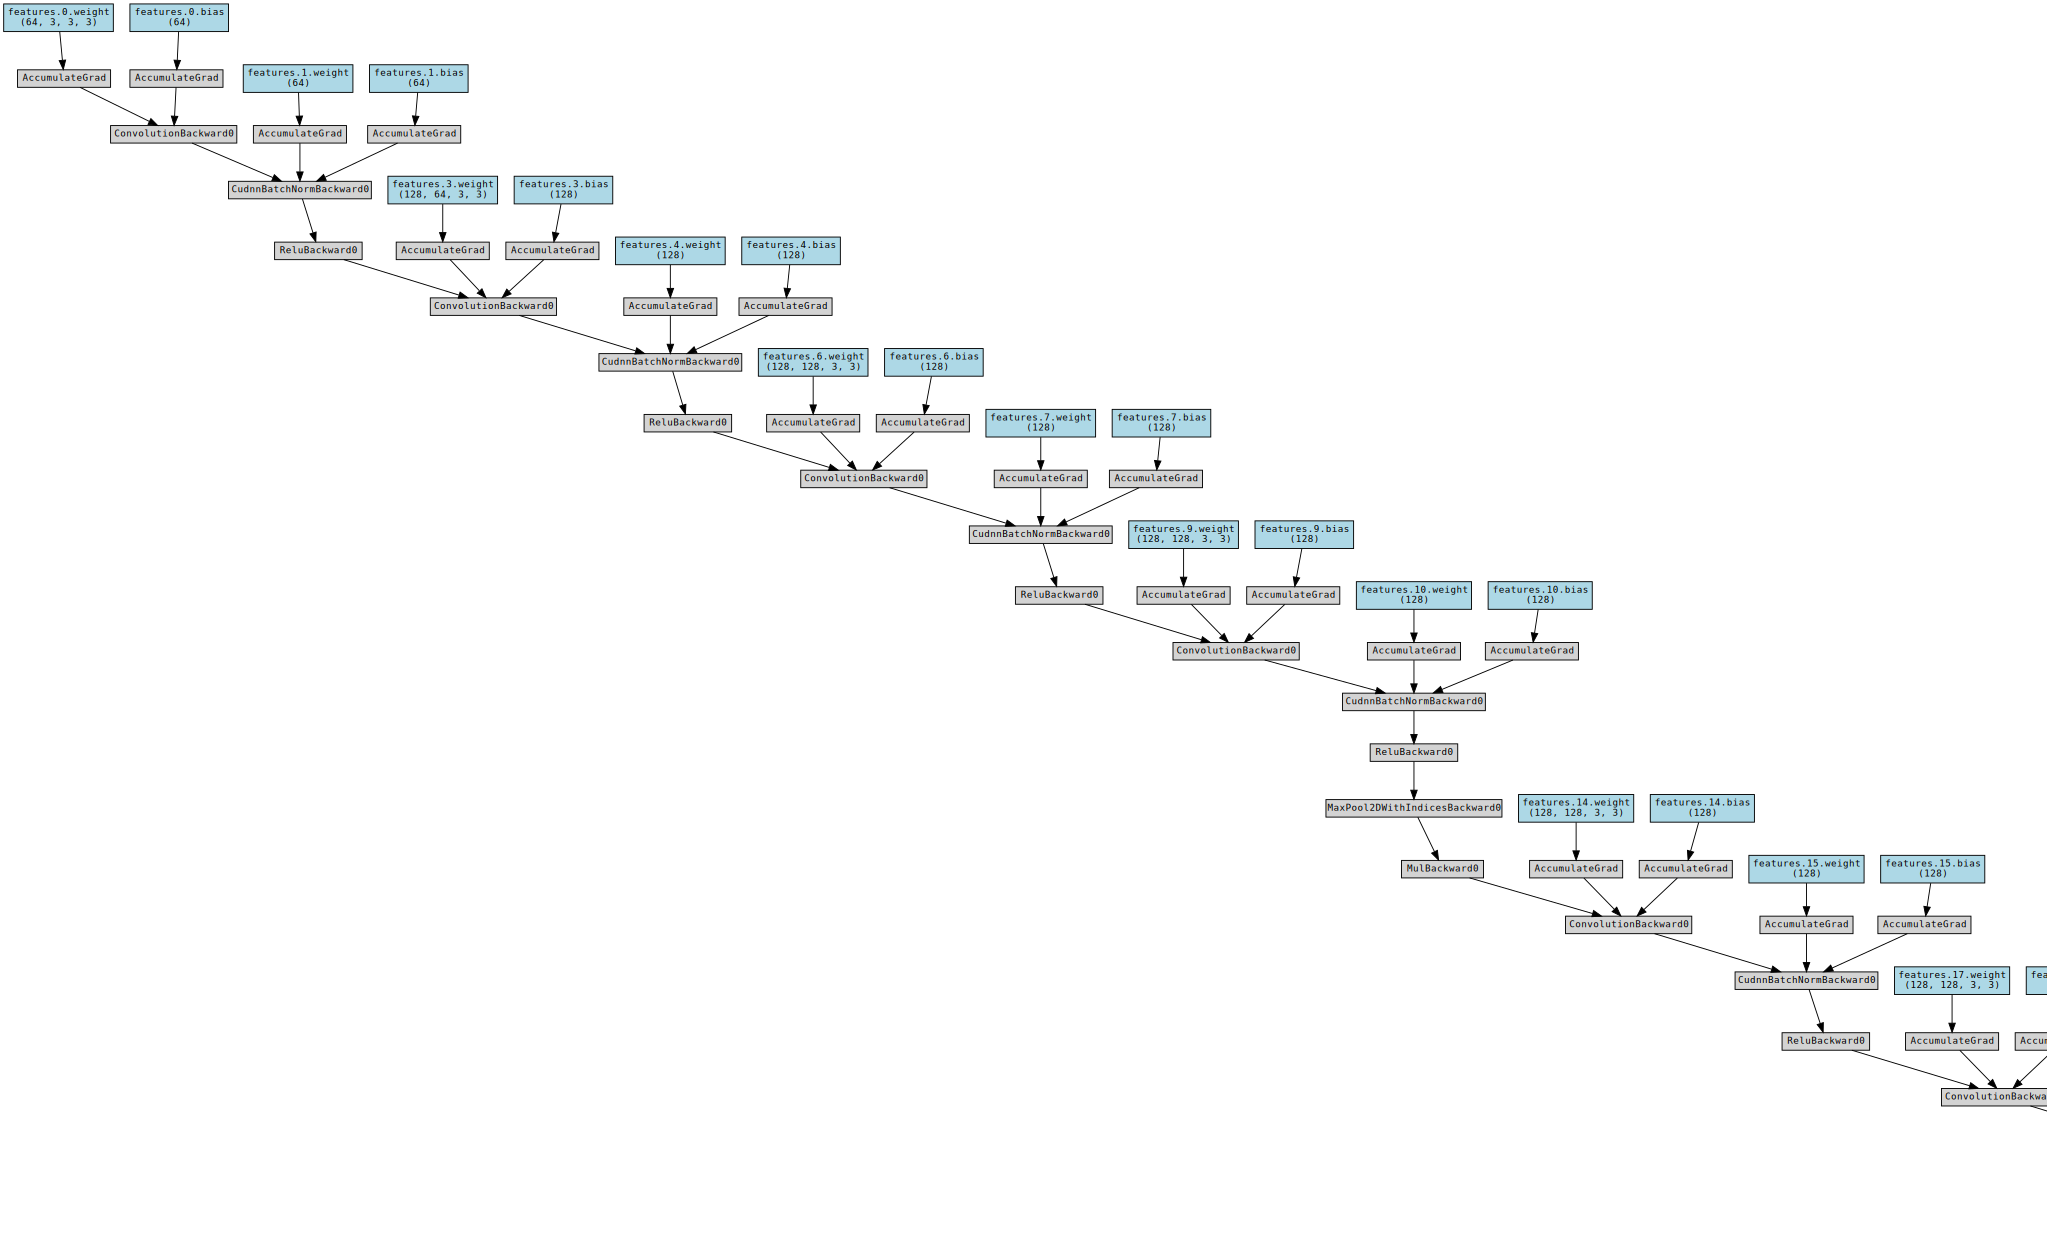

In [ ]:
from torchviz import make_dot
x = torch.zeros(100, 3, 32, 32, dtype=torch.float, requires_grad=False).to(DEVICE)
yhat = model(x)
make_dot(yhat, params=dict(list(model.named_parameters())))

# Build Train and test


In [ ]:
import torch.nn as nn
cifar_canvas = hl.Canvas()
cifar_history = hl.History()
class TRAIN_MODEL:
  def __init__(self,data_loader,EPOCH=10,patience=3):
    self.data_loader=data_loader
    self.model = simplenet().to(DEVICE)


    ##Batch loss
    self.batch_train_loss=[]
    self.EPOCH=EPOCH


  def train(self):

    optimizer = torch.optim.Adam(self.model.parameters())
    for epoch in range(self.EPOCH):
        # để theo dõi TrainLoss khi mô hình đào tạo
        train_losses = []


        ###################
        # train the model #
        ###################
        sum_train_loss=0.0
        for images, label in self.data_loader.train_loader:
          images, label = images.to(DEVICE), label.to(DEVICE)
          optimizer.zero_grad()
          output = self.model(images)
          batchloss = F.cross_entropy(output,label)
          batchloss.backward()
          sum_train_loss+= batchloss.item()
          optimizer.step()
          pred_labels = np.argmax(output.detach().cpu().numpy(), 1)
          accuracy = np.mean(pred_labels == label.detach().cpu().numpy())
          cifar_history.log(epoch,
                              loss=1-accuracy, accuracy=accuracy)



        #Add Loss
        self.batch_train_loss.append(sum_train_loss)
        print_msg = ('[{}/{}]'.format(epoch+1,self.EPOCH) + f'train loss: {sum_train_loss:.5f} ')

        print(print_msg)

    torch.save(self.model.state_dict(), MODELNAME)



# Case 10 epoch

In [ ]:
MyModel=TRAIN_MODEL(Data,10)
MyModel.train()

[1/10]train loss: 710.54758 
[2/10]train loss: 473.46729 
[3/10]train loss: 378.92277 
[4/10]train loss: 322.30676 
[5/10]train loss: 281.08038 
[6/10]train loss: 254.59657 
[7/10]train loss: 231.69235 
[8/10]train loss: 212.69483 
[9/10]train loss: 193.82520 
[10/10]train loss: 182.54400 


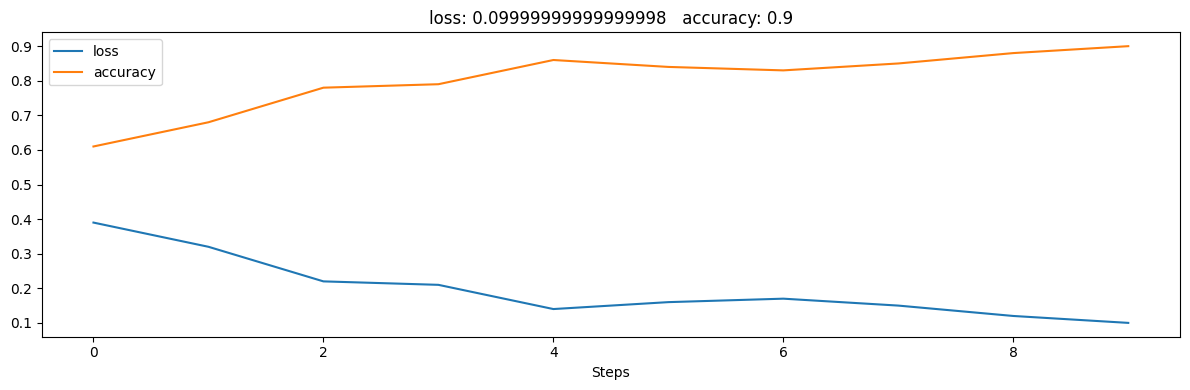

In [ ]:
cifar_canvas.draw_plot([cifar_history["loss"], cifar_history["accuracy"]])

In [ ]:
test_error=[]
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
def test(Data):
  test_canvas= hl.Canvas()
  test_history = hl.History()
  correct = 0
  total = float(len(Data.test_loader.dataset))
  model =  simplenet().to(DEVICE)
  model.load_state_dict(torch.load(MODELNAME))
  model.eval()
  i=0
  for images, labels in Data.test_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    y = model(images).to(DEVICE)
    pred_labels = y.max(dim=1)[1]
    correct = correct + (pred_labels == labels).sum()
    test_history.log(i,loss=1-correct/total, accuracy=correct/total)
    if i%10==0:
      test_canvas.draw_plot([test_history["loss"], test_history["accuracy"]])
    i+=1

  print("correct: ", correct.item())
  print("total: ", total)
  print("accuracy: ", correct.item()/total)


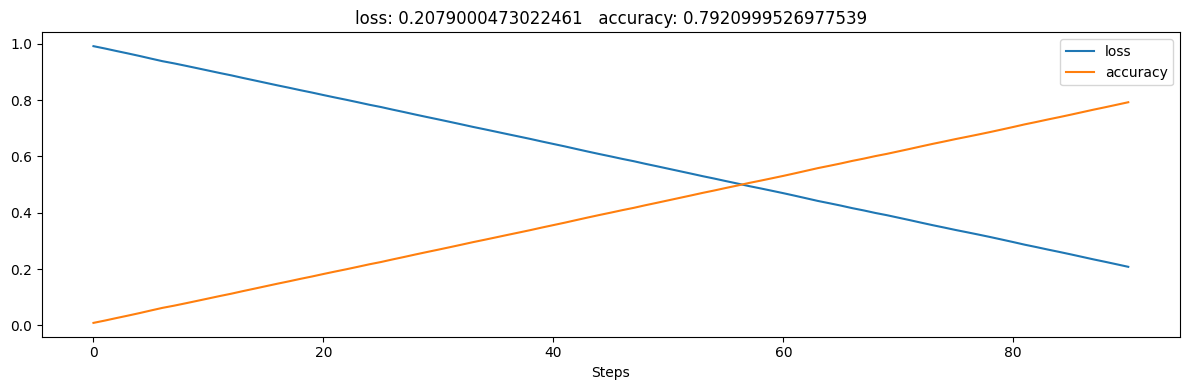

correct:  8713
total:  10000.0
accuracy:  0.8713


In [ ]:
test(Data)

# Case 15 epoch

In [ ]:
MyModel=TRAIN_MODEL(Data,15)
MyModel.train()

[1/15]train loss: 699.95222 
[2/15]train loss: 471.45805 
[3/15]train loss: 375.15143 
[4/15]train loss: 318.73962 
[5/15]train loss: 283.46617 
[6/15]train loss: 255.49453 
[7/15]train loss: 233.20867 
[8/15]train loss: 213.09646 
[9/15]train loss: 196.72600 
[10/15]train loss: 182.77878 
[11/15]train loss: 171.07478 
[12/15]train loss: 157.01921 
[13/15]train loss: 148.52089 
[14/15]train loss: 139.12504 
[15/15]train loss: 130.30402 


In [ ]:
test_error=[]

def test(Data):
  test_canvas= hl.Canvas()
  test_history = hl.History()
  correct = 0
  total = float(len(Data.test_loader.dataset))
  model =  simplenet().to(DEVICE)
  model.load_state_dict(torch.load(MODELNAME))
  model.eval()
  i=0
  for images, labels in Data.test_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    y = model(images).to(DEVICE)
    pred_labels = y.max(dim=1)[1]
    correct = correct + (pred_labels == labels).sum()
    test_history.log(i,loss=1-correct/total, accuracy=correct/total)
    if i%10==0:
      test_canvas.draw_plot([test_history["loss"], test_history["accuracy"]])
    i+=1

  print("correct: ", correct.item())
  print("total: ", total)
  print("accuracy: ", correct.item()/total)


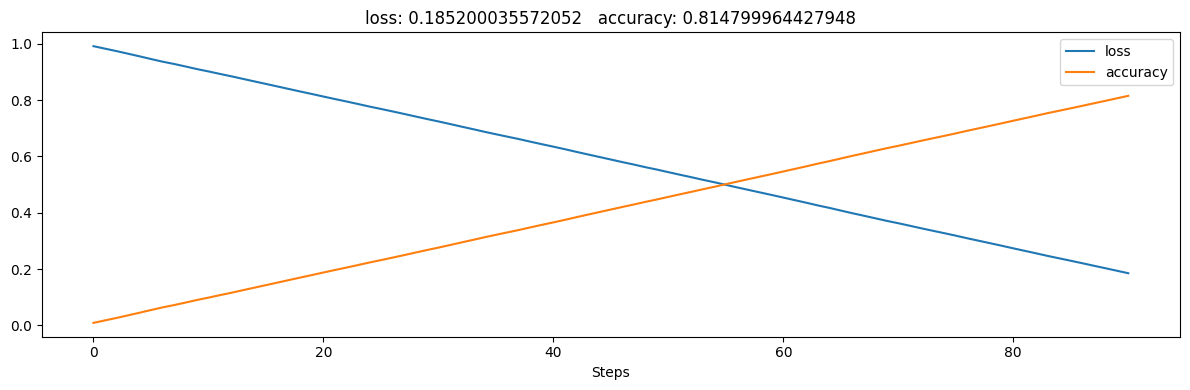

correct:  8960
total:  10000.0
accuracy:  0.896


In [ ]:
test(Data)

# Case 20 epoch

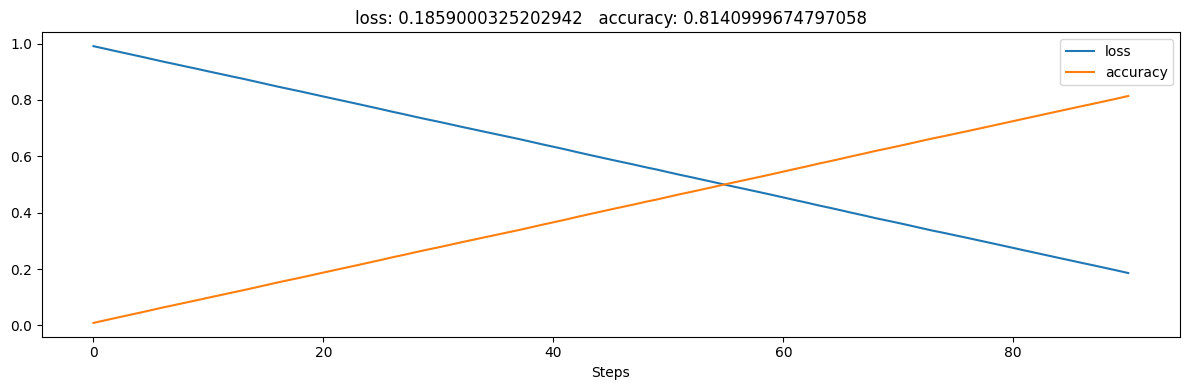

correct:  8957
total:  10000.0
accuracy:  0.8957


In [ ]:
MyModel=TRAIN_MODEL(Data,20)
MyModel.train()
test_error=[]

def test(Data):
  test_canvas= hl.Canvas()
  test_history = hl.History()
  correct = 0
  total = float(len(Data.test_loader.dataset))
  model =  simplenet().to(DEVICE)
  model.load_state_dict(torch.load(MODELNAME))
  model.eval()
  i=0
  for images, labels in Data.test_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    y = model(images).to(DEVICE)
    pred_labels = y.max(dim=1)[1]
    correct = correct + (pred_labels == labels).sum()
    test_history.log(i,loss=1-correct/total, accuracy=correct/total)
    if i%10==0:
      test_canvas.draw_plot([test_history["loss"], test_history["accuracy"]])
    i+=1

  print("correct: ", correct.item())
  print("total: ", total)
  print("accuracy: ", correct.item()/total)
test(Data)

# Case 25 epoch

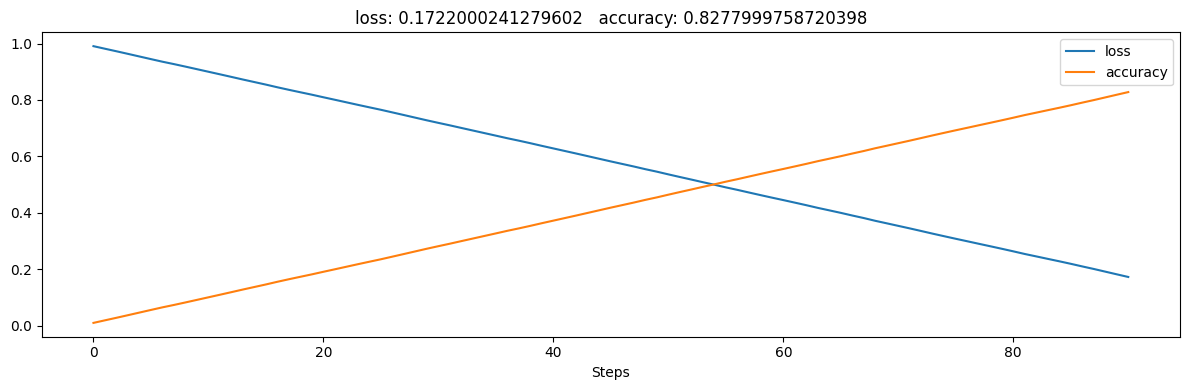

correct:  9105
total:  10000.0
accuracy:  0.9105


In [ ]:
MyModel=TRAIN_MODEL(Data,25)
MyModel.train()

test_error=[]

def test(Data):
  test_canvas= hl.Canvas()
  test_history = hl.History()
  correct = 0
  total = float(len(Data.test_loader.dataset))
  model =  simplenet().to(DEVICE)
  model.load_state_dict(torch.load(MODELNAME))
  model.eval()
  i=0
  for images, labels in Data.test_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    y = model(images).to(DEVICE)
    pred_labels = y.max(dim=1)[1]
    correct = correct + (pred_labels == labels).sum()
    test_history.log(i,loss=1-correct/total, accuracy=correct/total)
    if i%10==0:
      test_canvas.draw_plot([test_history["loss"], test_history["accuracy"]])
    i+=1

  print("correct: ", correct.item())
  print("total: ", total)
  print("accuracy: ", correct.item()/total)
test(Data)

# Case 30 epoch

In [ ]:
MyModel=TRAIN_MODEL(Data,30)
MyModel.train()

[1/30]train loss: 701.15234 
[2/30]train loss: 478.47530 
[3/30]train loss: 383.26818 
[4/30]train loss: 325.28504 
[5/30]train loss: 284.06107 
[6/30]train loss: 254.73067 
[7/30]train loss: 231.64849 
[8/30]train loss: 212.27579 
[9/30]train loss: 195.66790 
[10/30]train loss: 182.91283 
[11/30]train loss: 168.02137 
[12/30]train loss: 159.98189 
[13/30]train loss: 149.53637 
[14/30]train loss: 138.86571 
[15/30]train loss: 129.73635 
[16/30]train loss: 123.11435 
[17/30]train loss: 116.20904 
[18/30]train loss: 109.16624 
[19/30]train loss: 102.13765 
[20/30]train loss: 97.28100 
[21/30]train loss: 90.96382 
[22/30]train loss: 87.10080 
[23/30]train loss: 85.30679 
[24/30]train loss: 78.60125 
[25/30]train loss: 76.23424 
[26/30]train loss: 71.39898 
[27/30]train loss: 67.45665 
[28/30]train loss: 66.02653 
[29/30]train loss: 63.22616 
[30/30]train loss: 60.65451 


In [ ]:
test_error=[]

def test(Data):
    test_canvas= hl.Canvas()
    test_history = hl.History()
    correct = 0
    total = float(len(Data.test_loader.dataset))
    model =  simplenet().to(DEVICE)
    model.load_state_dict(torch.load(MODELNAME))
    model.eval()
    i=0
    for images, labels in Data.test_loader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      y = model(images).to(DEVICE)
      pred_labels = y.max(dim=1)[1]
      correct = correct + (pred_labels == labels).sum()
      test_history.log(i,loss=1-correct/total, accuracy=correct/total)
      if i%10==0:
        test_canvas.draw_plot([test_history["loss"], test_history["accuracy"]])
      i+=1

    print("correct: ", correct.item())
    print("total: ", total)
    print("accuracy: ", correct.item()/total)

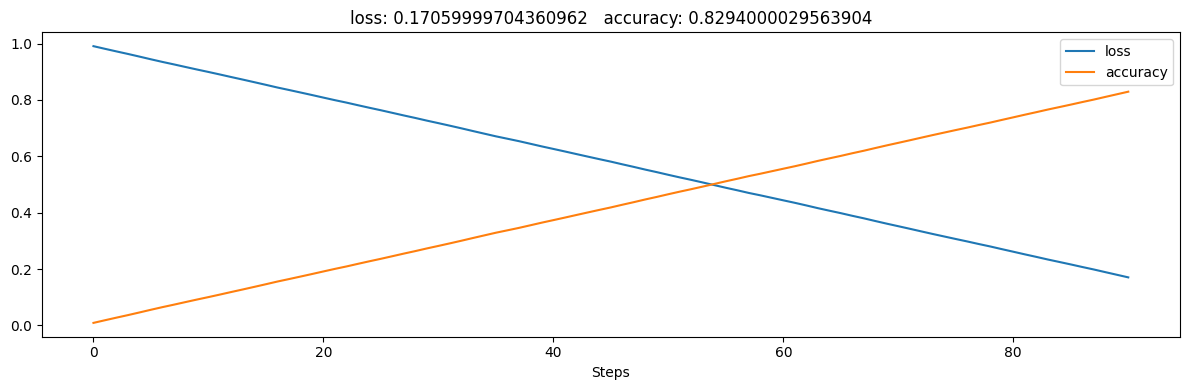

correct:  9121
total:  10000.0
accuracy:  0.9121


In [ ]:
test(Data)